# Maxence Lasbordes | MASH

In [187]:
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import string

# HW Instructions

## 🚧 Cells
All the cells identified with a 🚧 should be completed, either by a code or an written answer.
You can add as many cells as you want, but in general cells are already in place.


🚧 **TODO** 🚧

*Requires to complete a code (can be completed with optional text cells if you find it relevant).*

or

🚧 **Question** 🚧

*Requires a written answer (can be completed with optional code cells if you find it relevant).*

## 🔴 Test cells
Cells identified with 🔴 should be left untouched and shouldn't return any error.

## Presentation
The overall presentation of the notebook will account in the grading process.
Some advice:
- Give title to your figures.
- Put legends on the figures.
- Comment the figures if they are not self-explanatory.
- Add comment in the code if not self-explanatory.
- Review your notebook before submitting.
- Feel free to add any additional illustration if you find it will bring something.
- Remain as concise as possible when answering written answer, emphasize the important points.

**We cannot debug every notebooks. The notebook should run entirely from the start to the end without any error. If one cell returns an error during the execution, only the cells before the error will be graded.**



# HW Introduction

## Hands on with NLP preprocessing

The goal of this first homework is to introduce the preprocessing steps in NLP. This step is necessary, very valuable but often not emphasized enough (because it is boring). 

## Plan

1. Load the data
2. Analyze and clean the text data
3. Format the texts for Deep Learning models and pytorch (i.e. tokenize, etc).

## Notations

Throughout the HW, a text will be called either **document** or **text**.


# I - Data loading

In [188]:
def download_imdb(output_path: str, force_download: bool = False):
    """Save the data to `output_path`."""
    output_path = Path(output_path)
    if (not output_path.is_file()) or force_download:
        gdd.download_file_from_google_drive(
            file_id="1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz",
            dest_path=output_path,
        )
    return

In [189]:
DATA_PATH = "data/imdb_reviews.csv"
download_imdb(output_path=DATA_PATH, force_download=False)

🚧 **TODO** 🚧

Read the file to a Pandas dataframe (the file is stored as a csv). Make sure the "review" field is of dtype `string` and label of dtype `int`.

Hint: https://pandas.pydata.org/docs/user_guide/text.html (you can specify the `dtype` argument of pandas constructor).


In [190]:
df_imdb = pd.read_csv(DATA_PATH) # Load the data

In [191]:
text_column = df_imdb["review"].astype('string') # Ensure that the text column is 'string'
label_column = df_imdb["label"].astype(int) # Ensure that the label column is int

🔴 **TEST**

In [192]:
assert text_column.dtype == "string"
assert label_column.dtype == int

🚧 **TODO** 🚧

Print some values of the dataframe.
- Print 3 samples of text.
- Print their associated labels.
- Print some statistics of the dataset.



In [193]:
print("==== 3 first texts ====")
print(text_column.head(3)) # Display the 3 first texts


print("\n==== Associated labels of the 3 first texts ====")
print(label_column.head(3)) # Display the 3 first labels


print("\n=== Dataset statistics ===")
print("Number of texts")
print(len(text_column)) # Display the number of texts


print("\nAverage text length (in characters)")
print(text_column.str.len().mean()) # Display the average text length


print("\n% of positive texts")
print(sum(label_column == 1) / len(label_column) * 100) # Display the percentage of positive texts


==== 3 first texts ====
0    Once again Mr. Costner has dragged out a movie...
1    This is an example of why the majority of acti...
2    First of all I hate those moronic rappers, who...
Name: review, dtype: string

==== Associated labels of the 3 first texts ====
0    0
1    0
2    0
Name: label, dtype: int32

=== Dataset statistics ===
Number of texts
62155

Average text length (in characters)
1374.0382431019227

% of positive texts
49.66615718767597


## II - Clean and format the data.
For this first TP, we want to focus on very simple tasks.
Therefore, we want to avoid as much as possible rare and uncommon words that will be considered as outliers.

We will try to figure out what kind of cleaning we can perform, by having a look at the data.

The plan for this part will be:
1. Split the strings as a list of words.
2. Find the outliers in the corpus.
3. Propose some methods to clean them.

### 1. Tokenization
First, we will split our texts into words.
Splitting a string into a list of smaller substrings is called **tokenization**, and the substrings are called **tokens**.

The simplest way to tokenize a text is to split it by words, according to whitespaces.

Then, each word encountered in the training set is stored and uniquely identified through an id.



🚧 **Question** 🚧

By doing so, we put a huge emphasis on words within documents.

a) Intuitively, why is it relevant? For instance compare to splitting by character.

b) Cite some methods discussed during the course that rely on word-based representations of documents.

**Answer**

a) Using words is relevant because a word provides much more meaning and context compared to a single letter. A single letter lacks meaning and does not provide significant information without its context and the surrounding characters.

b) Methods like: Bag of Words, Word embeddings(Glove, FastText).

🚧 **TODO** 🚧

Implement a tokenizer based on whitespace splitting. For now, the tokenizer should only be able to store each unique word found in the dataset.

In [194]:
class WhiteSpaceTokenizer:
    def __init__(self):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split()

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        current_id = 0
        for text in tqdm(corpus):
            
            # Split into substrings.
            list_tokens = self.split_text(text) # Split the text into a list of strings

            for token in list_tokens:

                # Add the token to the vocabulary
                token_id = self.vocab.get(token, None)

                token_not_in_vocab = token_id is None # True if the token is not in the vocabulary
                if token_not_in_vocab:
                    self.vocab[token] = current_id # Add the token to the vocabulary
                    self.id_to_token[current_id] = token # Add the current_id to the id_to_token
                    self.frequencies[current_id] = 0
                    token_id = current_id
                    current_id += 1

                self.frequencies[token_id] += 1

        # Total number of words in vocab.
        self.num_words = len(self.vocab)
        print(f"Built a vocabulary of {self.num_words} words.")

🔴 **TEST**

In [195]:
toy_corpus = ["a cat", "a dog"]
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(toy_corpus)
assert tokenizer.vocab == {"a": 0, "cat": 1, "dog": 2}
assert tokenizer.frequencies == {0: 2, 1: 1, 2: 1}
assert tokenizer.num_words == 3

  0%|          | 0/2 [00:00<?, ?it/s]

Built a vocabulary of 3 words.


🚧 **TODO** 🚧

Fits the tokenizer on the imdb reviews.

In [196]:
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(text_column)

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 474682 words.


### 2. Noise analysis

🚧 **TODO** 🚧

Print 50 random tokens.

In [197]:
sample = random.sample(list(tokenizer.vocab.keys()), 50)
print(sample) # Display 50 random words from the vocabulary

['Mindful', 'Larnia...but', 'digital.<br', "Lung's", '*.', '1st.)', 'virginhood', 'Marianne', "'Magic", '(Alessandra', 'Fermilab.', 'Weave', 'no,Mark', 'Dearest.\\"', 'terrorized', 'mandartory', '(Chuck', '"He-Man."', 'thinkgeek.com', 'Kirsten,', "'Don't", 'Encounter,', 'handed.', 'HergÃ©', 'bathing.<br', 'MIND...BECAUSE', '\\"kissing\\"', 'detainees', 'Dainton', 'alarmed', 'Haulocast', 'mm.\\".', "'past", 'cuckold', 'course--well,', 'oud.<br', 'accident.after', '"Morpheus"', 'Guffman.', '(nr.', 'butt-nasty', 'carp', 'Laughter.', 'Fishel', 'kattan', 'ever-growing', 'VERDOUX,', '"Gabriel', 'pathetic...the', 'Cervantes(Don']


🚧 **QUESTION** 🚧

What do you think of the tokens? Do they look like simple "words" as expected?

Analyze the noise and explain why we got such weird vocabulary.

**Answer**

- Many tokens don't look like simple words. In fact, we can find numbers or even words with symbols like $!$ $<$ $'$ etc. This is normal because the tokenizer splits only on spaces, it doesn't differentiate between words and attached symbols.

- Besides certain 'normal' tokens, the frequencies are low, especially for tokens containing symbols, numbers, or punctuation, as they appear only a few times in the dataset. Since the current tokenizer does not handle punctuation or symbols effectively, many tokens are treated as different, even though they represent the same words (because they have a specific symbol attached to them for instance).



Text(0.5, 1.0, 'Word frequency of 50 random words')

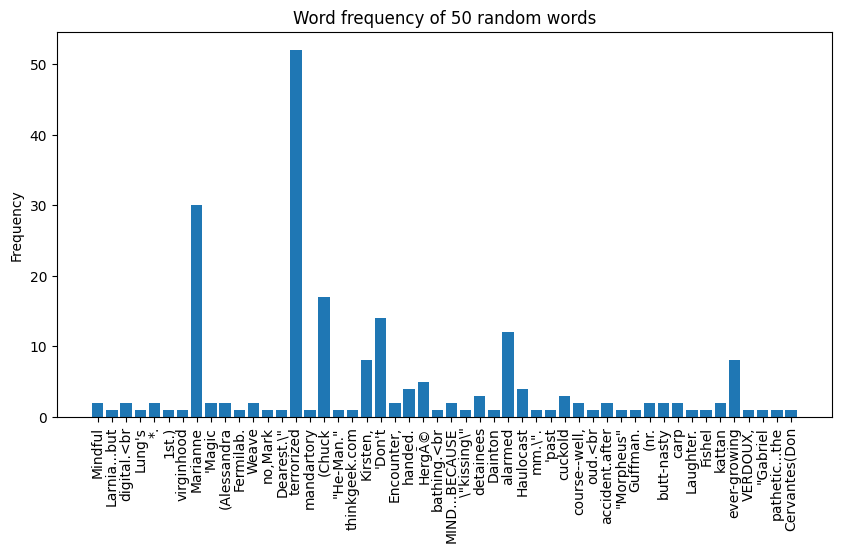

In [198]:
frequencies = [tokenizer.frequencies[tokenizer.vocab[word]] for word in sample]
plt.figure(figsize=(10, 5))
plt.bar(sample, frequencies)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.title("Word frequency of 50 random words")

We can see here that most words with symbols attached to them, have a very low frequency, which confirms our analysis.

### 3. Cleaning

🚧 **TODO** 🚧

You are going to implement some of the classical cleaning methods.
1. Lower case the string.
2. String normalization, i.e., replace accentuated characters by standard version ("â -> a") (hint: https://stackoverflow.com/a/14121678).
3. Remove non alpha-numeric characters (use Python regex package `re`).
4. Replace numeric characters by the token `'<NUM>'` (use the package `re`).
5. Remove double whitespaces (use the package `re`).


In [199]:
import unicodedata
import re

In [200]:
def preprocess_text(text: str) -> str:
    
    text = text.lower() # Lower case the text
    
    text = unicodedata.normalize('NFKD', text) # String normalization
    text = text.replace('-', ' ')
    
    text = re.sub(r'[^a-z0-9\s]', '', text) # Remove non alpha-numeric characters
    
    text = re.sub(r'\d+', '<NUM>', text) # Replace numeric characters by the token '<NUM>'
    
    text = re.sub(r'\s+', ' ', text) # Remove multiple whitespaces
    
    return text

🔴 **TEST**

In [201]:
noisy_text = "Ï   lîved  in    San-Françisco...  ! for 12 years."
clean_text = "i lived in san francisco for <NUM> years"
assert preprocess_text(noisy_text) == clean_text

🚧 **TODO** 🚧

Add column `clean_review` to the dataframe, with the clean text.

Store the `clean_review` column to the variable `clean_column`.

In [202]:
df_imdb["clean_review"] = df_imdb['review'].apply(preprocess_text) # Apply the preprocessing to the text column

clean_column = df_imdb['clean_review'] 

🚧 **TODO** 🚧

Run the tokenizer on the clean text and print 50 random tokens.

In [203]:
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(clean_column)

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 151837 words.


In [204]:
sample = random.sample(list(tokenizer.vocab.keys()), 50)
print(sample) # Display 50 random words from the vocabulary

['polaha', 'congratulatedbr', 'dupebr', 'dinsey', 'goffenking', 'hoegers', 'petulantly', 'davisjr', 'simplebut', 'disreguarded', 'twoface', 'eamon', 'violator', 'unvaried', 'poretta', 'harltey', 'connotation', 'randle', 'blackish', 'bates', 'frankly', 'shepard', 'rainy', 'catchingand', 'yetbuying', 'reinforcement', 'pal', 'storylinea', 'begrudges', 'engage', 'latterday', 'motley', 'scoresound', 'rescuing', 'documentary', 'intercede', 'sumuru', 'fernanda', 'believabilty', 'confederates', 'shurikenthrowing', 'partgood', 'oldnot', 'moviemore', 'reuses', 'cupbr', 'flashless', 'malhotra', 'apeschimps', 'bomberbr']


🚧 **Question** 🚧

What do you think of the new tokens? Are they better? What common noise still remain? (Feel free to print more tokens to get a better intuition).

Suggest some methods to improve again the tokenization (at least 2), based on either these results or on something you think we could have done better.

**Answer**

- The new tokens are way better and cleaner. Also the Vocabulary size has decreased by a lot, which makes sense considering the cleaning we made. By removing special characters and numbers, the majority of noise has been eliminated.
- The common noise that still remains comes from plurals, for instance 'dog' and 'dogs' are considered different words, and from misspelled words like 'hhoorriibbllee'.
- To improve the tokenizer we could add a Spell Correction to misspelled words. 

### Tokens analysis


🚧 **TODO** 🚧

Show the frequencies repartition.
This should be a histogram, with 100 bins, with the frequencies on the x axis and the number of words associated to the frequencies on the y axis (see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html).

Use logarithm scale for y.

Text(0.5, 1.0, 'Histogram of Word Frequencies')

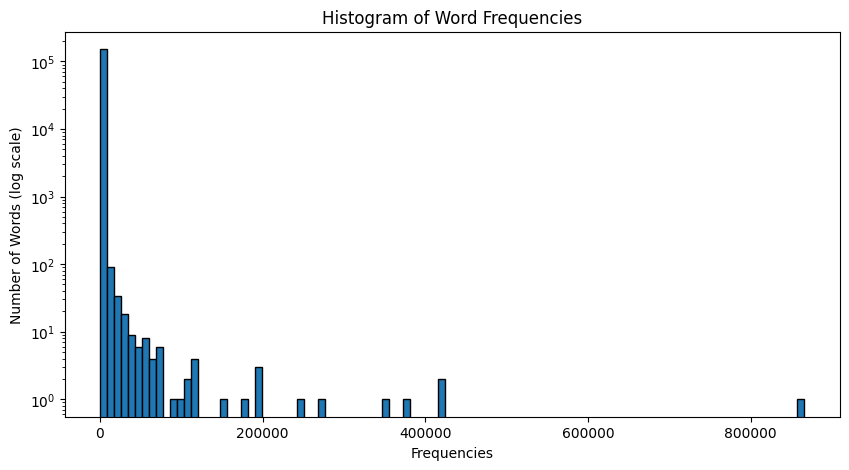

In [205]:
frequencies = [tokenizer.frequencies[tokenizer.vocab[word]] for word in list(tokenizer.vocab.keys())]
plt.figure(figsize=(10, 5))
plt.hist(frequencies, bins=100, edgecolor='black')
plt.yscale('log') # Set logarithmic scale for y-axis
plt.xlabel('Frequencies')
plt.ylabel('Number of Words (log scale)')
plt.title('Histogram of Word Frequencies')

🚧 **Question** 🚧

What do you think of the repartition?

**Answer**

- The distribution roughly follows Zipf's law, which makes sense.


🚧 **TODO** 🚧

Plot the frequencies repartition. Find the best corresponding Zipf law (seen during the course) and plot it on the same figure.

Text(0.5, 1.0, 'Histogram of Word Frequencies')

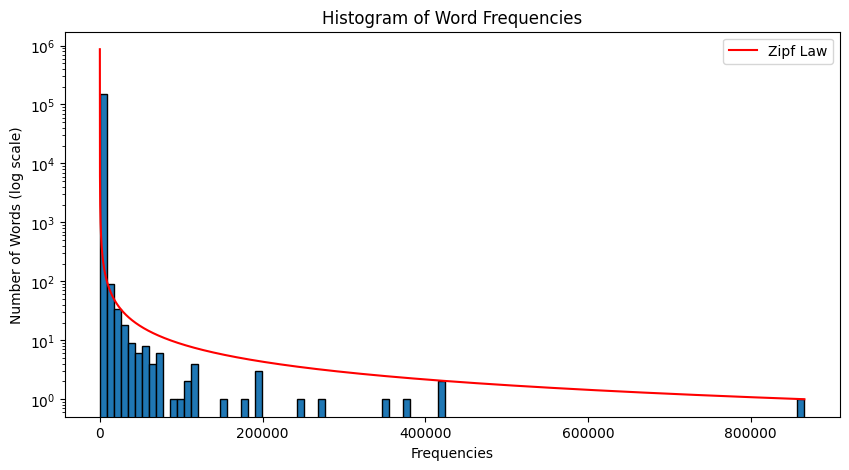

In [206]:
frequencies = [tokenizer.frequencies[tokenizer.vocab[word]] for word in list(tokenizer.vocab.keys())]
max_freq = max(frequencies)

# Zipf's law: f(r) = C / r^s
s = 1
C = max_freq 
ranks = np.arange(1, max_freq)
zipf_values = C / (ranks ** s)

plt.figure(figsize=(10, 5))
plt.plot(ranks, zipf_values, label=f'Zipf Law', color='red') # Plot Zipf's law
plt.hist(frequencies, bins=100, edgecolor='black') # Plot the histogram of word frequencies
plt.yscale('log') # Set logarithmic scale
plt.xlabel('Frequencies')
plt.ylabel('Number of Words (log scale)')
plt.legend()
plt.title('Histogram of Word Frequencies')

- We can clearly see here that the repartition follows a Zipf's law repartition.

## III - DataLoading

This final part aims at making your dataset compatible with PyTorch.

### Text representation

Since we plan to work with PyTorch, we need to work with `tensors`. But since a text is only composed of strings, we need to find some numerical representations for the text.

The most basic method is to represent a text by list of tokens. We already used a simple WhiteSpace tokenizer earlier to analyze our texts before cleaning. Now we will use it to *represent* the texts.

🚧 **TODO** 🚧

Modify the code of the `WhiteSpaceTokenizer` so that it could encode a text into a list of token ids and do the reverse (i.e. decode a list of token ids to a text).

In [207]:
class WhiteSpaceTokenizer:
    def __init__(self):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split()

    def encode(self, text: str) -> List[int]:
        """Take a text as input and return its associated tokenization, as a list of ids."""
        return [self.vocab[token] for token in self.split_text(text)]

    def decode(self, ids: List[int]) -> str:
        return ' '.join([self.id_to_token.get(id) for id in ids])

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        current_id = 0
        for text in tqdm(corpus):

            # Split into substrings.
            list_tokens = self.split_text(text)

            for token in list_tokens:

                # Add the token to the vocabulary
                token_id = self.vocab.get(token, None)

                token_not_in_vocab = token_id is None
                if token_not_in_vocab:
                    self.vocab[token] = current_id
                    self.id_to_token[current_id] = token
                    self.frequencies[current_id] = 0
                    token_id = current_id
                    current_id += 1

                self.frequencies[token_id] += 1

        # Total number of words in vocab.
        self.num_words = len(self.vocab)
        print(f"Built a vocabulary of {self.num_words} words.")

🔴 **TEST**

In [208]:
tokenizer = WhiteSpaceTokenizer()
toy_dataset = ["the cat is in the kitchen", "i have a dog"]
tokenizer.fit(toy_dataset)
text = "i have a kitchen"
assert tokenizer.encode(text) == [5, 6, 7, 4]
assert tokenizer.decode([0, 1, 2, 7, 8]) == "the cat is a dog"

  0%|          | 0/2 [00:00<?, ?it/s]

Built a vocabulary of 9 words.


🚧 **TODO** 🚧 Now fit it on your dataset.

In [209]:
class WhiteSpaceTokenizer:
    def __init__(self):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}
        
        # Add the <UNK> token
        self.UNK_TOKEN = "<UNK>"
        self.UNK_ID = 0  
        self.vocab[self.UNK_TOKEN] = self.UNK_ID
        self.id_to_token[self.UNK_ID] = self.UNK_TOKEN
        self.frequencies[self.UNK_ID] = 0

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split()

    def encode(self, text: str) -> List[int]:
        """Take a text as input and return its associated tokenization, as a list of ids."""
        return [self.vocab.get(token, self.UNK_ID) for token in self.split_text(text)]

    def decode(self, ids: List[int]) -> str:
        return ' '.join([self.id_to_token.get(id) for id in ids])

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        current_id = 1 # Start at 1 because 0 is reserved for the <UNK> token
        for text in tqdm(corpus):

            # Split into substrings.
            list_tokens = self.split_text(text)

            for token in list_tokens:

                # Add the token to the vocabulary
                token_id = self.vocab.get(token, None)

                token_not_in_vocab = token_id is None
                if token_not_in_vocab:
                    self.vocab[token] = current_id
                    self.id_to_token[current_id] = token
                    self.frequencies[current_id] = 0
                    token_id = current_id
                    current_id += 1

                self.frequencies[token_id] += 1

        # Total number of words in vocab.
        self.num_words = len(self.vocab)
        print(f"Built a vocabulary of {self.num_words} words.")

- Above is the corrected tokenizer with the <UNK> token added !

In [210]:
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(clean_column)

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 151838 words.


🚧 **Question** 🚧
Look at the following code:

In [211]:
tokenizer.encode("the king is in the câstle")

[17, 3665, 58, 40, 17, 0]

a) Does it raise an exception? Explain what is the problem with the above situation.

b) In which real life scenario could such a situation appear?

**Answer**

a) Yes an error is raised. The problem comes from the fact that 'câstle' isn't in the vocabulary of our tokenizer.

b) Such situations are very likely to occur, it is common for people to make typos or for words to have accents. So the situation of having to deal with an unknown word is very common.


🚧 **TODO** 🚧

Propose a simple modification of the tokenizer code such that it doesn't raise an exception anymore. It should handle the presence of any unknown token.

The following code should't raise any exception.

🔴 **TEST**

In [212]:
allowed_characters = (string.ascii_uppercase + string.digits).replace(" ", "")
for _ in range(1000):
    print(tokenizer.decode([tokenizer.UNK_ID]))
    word_that_do_not_exist = "".join(random.choices(allowed_characters, k=100))
    encoding = tokenizer.encode(f"the king is in the {word_that_do_not_exist}")
    print(encoding)
    print(tokenizer.decode(encoding))
    assert tokenizer.decode(encoding) == "the king is in the <UNK>"

<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]
the king is in the <UNK>
<UNK>
[17, 3665, 58, 40, 17, 0]

### Dataset for PyTorch
We will be working wtth PyTorch most of the time.
A good practice is to always iterate through a `torch.utils.data.DataLoader`, coupled with `torch.utils.data.Dataset`.

🚧 **TODO** 🚧

We will construct our custom `Dataset` class, that should be fully compatible with the PyTorch API. According to the [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files), such a dataset should implement at least three methods, `__init__`, `__len__`, `__getitem__`. Complete the following code such that the dataset yields a list of texts.

Requirements:
1. The dataset class should read the data from the csv_file stored in `DATA_PATH`.
2. The dataset should output the raw text, without any cleaning.

In [213]:
from torch.utils.data import Dataset


class IMDBDataset(Dataset):
    def __init__(self, file_path: str):
        self.df = pd.read_csv(file_path) # Load the data

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        return self.df['review'][idx], self.df['label'][idx] # Return the text and its label

🔴 **TEST**

In [214]:
imdb_dataset = IMDBDataset(file_path=DATA_PATH)
text, label = imdb_dataset[0]
assert text == text_column[0]
assert label == label_column[0]

### DataLoader for PyTorch

Now that the dataset is ready, we should be able to iterate through it. This is done with a `DataLoader`.

The `DataLoader` also has some handy functionnalities:
1. Batch iteration.
2. Collate function.

The collate function corresponds to the argument `collate_fn` of the constructor of `torch.utils.data.DataLoader`.

This function is applied on the fly to each sample of the dataset.

Our `IMDBDataset` only outputs raw texts. During the iteration through the `DataLoader`, we would like to:
1. Clean the dataset with our cleaning function `preprocess_text`.
2. Convert the text to a list of tokens.
3. The `DataLoader`, for a batch size of `N`, should yield a dictionnary `{"token_ids": ..., "labels": ...,}` with `"token_ids"` corresponding to a list of `N` lists of tokens ids, and `"labels"` to a list of size `N` with the corresponding labels.

🚧 **TODO** 🚧

Write the `collate_fn` function so that the above requirements are satisfied (i.e., clean and tokenize).

In [215]:
tokenizer = WhiteSpaceTokenizer()
def collate_fn(batch):
    texts, labels = zip(*batch) # Unzip the batch
    cleaned_texts = [preprocess_text(text) for text in texts] # Clean the texts
    tokenized_texts = [tokenizer.encode(text) for text in cleaned_texts] # Tokenize the texts

    return {"token_ids": tokenized_texts, "labels": list(labels)}

In [216]:
from torch.utils.data import DataLoader

🔴 **TEST**

In [217]:
for batch_size in range(1, 10):
    dataloader = DataLoader(
        dataset=imdb_dataset, batch_size=batch_size, collate_fn=collate_fn
    )
    for batch in dataloader:
        token_ids = batch["token_ids"]
        labels = batch["labels"]
        assert len(token_ids) == batch_size
        assert len(labels) == batch_size
        assert isinstance(token_ids[0][0], int)
        assert (isinstance(labels[0], int)) or isinstance(labels[0], np.int64)
        break

🚧 **Question** 🚧

Write a concise summary on what you learned with this lab.

**Answer**

- I learned techniques for preprocessing text data: normalization, tokenization, and the creation of a custom dataset for PyTorch. I understood the importance of handling unknown tokens to make the model work properly. Also, I didn't know about the collate_fn function, which can be very useful.